In [21]:
import pandas as pd
import numpy as np

import ffn.core as ffn   # provides probabilistic momentum operator: ffn.calc_prob_mom(.)
import bt

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# plots of BT only work with this following command
%matplotlib inline

In [22]:
# daily returns
df_daily = pd.read_csv('raw_daily_prices.csv', parse_dates=True, index_col=0)
df_dailyReturns = df_daily.pct_change(axis=0)
df_dailyReturns.info()
df_dailyReturns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4972 entries, 2002-01-02 to 2021-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLK     4971 non-null   float64
 1   SPY     4971 non-null   float64
 2   TLT.O   4829 non-null   float64
 3   TAIL.K  1129 non-null   float64
 4   VIX     4971 non-null   float64
dtypes: float64(5)
memory usage: 233.1 KB


XLK       SPY     TLT.O    TAIL.K       VIX
2002-01-02       NaN       NaN       NaN       NaN       NaN
2002-01-03  0.043902  0.011339       NaN       NaN -0.060326
2002-01-04  0.006231  0.006676       NaN       NaN -0.041706
2002-01-07 -0.010836 -0.007057       NaN       NaN  0.072861
2002-01-08  0.007433 -0.002312       NaN       NaN -0.005014
...              ...       ...       ...       ...       ...
2021-09-24  0.000702  0.001647 -0.009774 -0.007248 -0.047236
2021-09-27 -0.009699 -0.002861 -0.003676  0.000000  0.056901
2021-09-28 -0.029641 -0.020152 -0.015577  0.008653  0.239339
2021-09-29 -0.001262  0.001683  0.001735 -0.001067 -0.029677
2021-09-30 -0.007181 -0.012222 -0.000139  0.006973  0.025709

[4972 rows x 5 columns]

In [23]:
# weekly
df_weekly = pd.read_csv('raw_weekly_prices.csv', parse_dates=True, index_col=0)
df_weeklyReturns = df_weekly.pct_change(axis=0)
df_weeklyReturns.info()
df_weeklyReturns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1031 entries, 2002-01-04 to 2021-10-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLK     1030 non-null   float64
 1   SPY     1030 non-null   float64
 2   TLT.O   1001 non-null   float64
 3   TAIL.K  234 non-null    float64
 4   VIX     1030 non-null   float64
dtypes: float64(5)
memory usage: 48.3 KB


XLK       SPY     TLT.O        TAIL.K       VIX
2002-01-04       NaN       NaN       NaN           NaN       NaN
2002-01-11  0.003416 -0.005857       NaN           NaN  0.031256
2002-01-18 -0.035899 -0.018779       NaN           NaN  0.032834
2002-01-25 -0.039151 -0.005444       NaN           NaN -0.043122
2002-02-01 -0.003689 -0.007196       NaN           NaN  0.012390
...              ...       ...       ...           ...       ...
2021-09-03  0.010492  0.009466 -0.000523 -2.664961e-03 -0.055446
2021-09-10 -0.005389 -0.007017 -0.005454  9.619496e-04  0.161918
2021-09-17 -0.008635 -0.008365  0.011906  3.256807e-03  0.017904
2021-09-24 -0.015005 -0.015526 -0.001440 -2.220446e-16  0.112009
2021-10-01 -0.020429 -0.008065 -0.033473 -8.433559e-03  0.021594

[1031 rows x 5 columns]

In [24]:
# calculate probabilistic momentum between returns series of two assets (ex. market x bonds)
# probabilistic momentum can be defined as the probability or confidence that one asset (left) is going to outperform the other (right).
# lookback period: n days (not business days)
# p_currentDate = reference date - usually the current date 
def checkForProbMomentum(p_returns:pd.DataFrame, left_ticker: str, right_ticker: str, 
                         p_currentDate=pd.Timestamp, p_lookbackPeriod=66):
    
    v_startDate = p_currentDate - pd.DateOffset(days=p_lookbackPeriod)
    v_returns = p_returns.loc[ v_startDate:p_currentDate, [left_ticker,right_ticker] ]
        
    v_leftReturns = v_returns.iloc[:,0]
    v_rightReturns = v_returns.iloc[:,1]
        
    mom = ffn.calc_prob_mom(v_leftReturns, v_rightReturns)
     
    return mom     

In [25]:
# get series of probabilistic momentum

startDate_str = '2017-04-07'  # date in which the prices of TAIL.K starts
endDate_str = '2021-10-01'    # last date of the returns dataframe
dateIndex= df_weeklyReturns.loc[startDate_str:endDate_str].index

print(f'Dates for Prob. Momentum computing:\n {dateIndex}\n\n')

market_ticker = 'SPY'
bonds_ticker = 'TAIL.K'

# dataframe that holds the prob. momentum values
column_prefix = 'probMon_' + market_ticker + '_' + bonds_ticker   
columns_name = [column_prefix + '_weekly', column_prefix + '_daily']
df_probMomentum = pd.DataFrame(index=dateIndex, columns=columns_name)

for date in dateIndex:
    v_currentDate = date
    
    # weekly
    mom_weekly = checkForProbMomentum(df_weeklyReturns, market_ticker, bonds_ticker, 
                                           v_currentDate, p_lookbackPeriod=60)
    df_probMomentum.loc[date,columns_name[0]] =  mom_weekly
        
    # daily
    mom_daily = checkForProbMomentum(df_dailyReturns, market_ticker, bonds_ticker, 
                                           v_currentDate, p_lookbackPeriod=60)
    df_probMomentum.loc[date,columns_name[1]] =  mom_daily
    

df_probMomentum

Dates for Prob. Momentum computing:
 DatetimeIndex(['2017-04-07', '2017-04-14', '2017-04-21', '2017-04-28',
               '2017-05-05', '2017-05-12', '2017-05-19', '2017-05-26',
               '2017-06-02', '2017-06-09',
               ...
               '2021-07-30', '2021-08-06', '2021-08-13', '2021-08-20',
               '2021-08-27', '2021-09-03', '2021-09-10', '2021-09-17',
               '2021-09-24', '2021-10-01'],
              dtype='datetime64[ns]', length=235, freq=None)




probMon_SPY_TAIL.K_weekly probMon_SPY_TAIL.K_daily
2017-04-07                       0.5                      0.5
2017-04-14                       0.5                 0.163753
2017-04-21                  0.183648                 0.428862
2017-04-28                   0.58577                 0.539936
2017-05-05                  0.602772                 0.562213
...                              ...                      ...
2021-09-03                  0.664162                  0.53864
2021-09-10                  0.697467                 0.518262
2021-09-17                  0.584454                 0.530089
2021-09-24                  0.520733                 0.528102
2021-10-01                  0.445725                 0.493607

[235 rows x 2 columns]

In [26]:
# organizing dataframe for visualization of results
v_threshold = pd.Series(data=0.5, index=dateIndex, name='threshold')
v_spy = df_weekly.loc[ pd.Timestamp(startDate_str):pd.Timestamp(endDate_str), 'SPY' ]
v_tail  = df_weekly.loc[ pd.Timestamp(startDate_str):pd.Timestamp(endDate_str), 'TAIL.K' ]
v_spy_logReturns = v_spy / v_spy.shift(1)
v_tail_logReturns = v_tail / v_tail.shift(1)

df_results = pd.concat([v_spy_logReturns, v_tail_logReturns, df_probMomentum, v_threshold], axis=1)
df_results

SPY    TAIL.K probMon_SPY_TAIL.K_weekly  \
2017-04-07       NaN       NaN                       0.5   
2017-04-14  0.995702  1.011742                       0.5   
2017-04-21  1.000542  1.003095                  0.183648   
2017-04-28  1.016206  0.978706                   0.58577   
2017-05-05  1.003015  0.997148                  0.602772   
...              ...       ...                       ...   
2021-09-03  1.009466  0.997335                  0.664162   
2021-09-10  0.992983  1.000962                  0.697467   
2021-09-17  0.991635  1.003257                  0.584454   
2021-09-24  0.984474  1.000000                  0.520733   
2021-10-01  0.991935  0.991566                  0.445725   

           probMon_SPY_TAIL.K_daily  threshold  
2017-04-07                      0.5        0.5  
2017-04-14                 0.163753        0.5  
2017-04-21                 0.428862        0.5  
2017-04-28                 0.539936        0.5  
2017-05-05                 0.562213        0.5  
...                             ...        ...  
2021-09-03                  0.53864        0.5  
2021-09-10                 0.518262        0.5  
2021-09-17                 0.530089        0.5  
2021-09-24                 0.528102        0.5  
2021-10-01                 0.493607        0.5  

[235 rows x 5 columns]

---
## YEAR: 2018

probMon_SPY_TAIL.K_weekly probMon_SPY_TAIL.K_daily  threshold
2018-01-05                  0.905564                 0.630955        0.5
2018-01-12                  0.904393                 0.665909        0.5
2018-01-19                  0.904795                 0.683847        0.5
2018-01-26                  0.944805                 0.686044        0.5
2018-02-02                  0.842832                 0.611406        0.5
2018-02-09                  0.469412                 0.493841        0.5
2018-02-16                   0.52964                 0.525031        0.5
2018-02-23                  0.521402                 0.524597        0.5
2018-03-02                  0.499356                  0.51137        0.5
2018-03-09                  0.488869                 0.519669        0.5
2018-03-16                  0.472128                 0.497765        0.5
2018-03-23                  0.432844                 0.458924        0.5
2018-03-30                  0.525088                  0.46372        0.5
2018-04-06                  0.398098                 0.471847        0.5
2018-04-13                  0.414528                 0.518957        0.5
2018-04-20                  0.496775                 0.495863        0.5
2018-04-27                  0.459348                 0.492407        0.5
2018-05-04                  0.439487                 0.506214        0.5
2018-05-11                  0.603399                 0.498286        0.5
2018-05-18                  0.748981                 0.513633        0.5
2018-05-25                  0.776431                 0.564946        0.5
2018-06-01                  0.642116                 0.548854        0.5
2018-06-08                  0.637553                 0.595411        0.5
2018-06-15                  0.690305                 0.567464        0.5
2018-06-22                  0.644032                 0.542085        0.5
2018-06-29                  0.500801                 0.522717        0.5
2018-07-06                   0.47775                 0.537916        0.5
2018-07-13                  0.538703                 0.525903        0.5
2018-07-20                  0.625957                 0.528379        0.5
2018-07-27                  0.593909                 0.544758        0.5
2018-08-03                  0.570256                 0.562802        0.5
2018-08-10                  0.665723                 0.530743        0.5
2018-08-17                  0.761095                 0.548283        0.5
2018-08-24                  0.759716                 0.565463        0.5
2018-08-31                  0.764375                 0.605356        0.5
2018-09-07                   0.67078                 0.577839        0.5
2018-09-14                  0.659157                 0.587533        0.5
2018-09-21                  0.723687                 0.589198        0.5
2018-09-28                  0.677906                 0.570958        0.5
2018-10-05                  0.804799                 0.552198        0.5
2018-10-12                  0.493529                  0.48652        0.5
2018-10-19                  0.410849                 0.480974        0.5
2018-10-26                  0.348286                  0.44065        0.5
2018-11-02                  0.315322                 0.464518        0.5
2018-11-09                    0.4229                 0.492625        0.5
2018-11-16                  0.372439                  0.46857        0.5
2018-11-23                  0.309736                 0.436513        0.5
2018-11-30                  0.435801                 0.469688        0.5
2018-12-07                  0.436293                 0.444129        0.5
2018-12-14                  0.433524                 0.456796        0.5
2018-12-21                  0.354957                  0.40428        0.5
2018-12-28                  0.226279                 0.463219        0.5

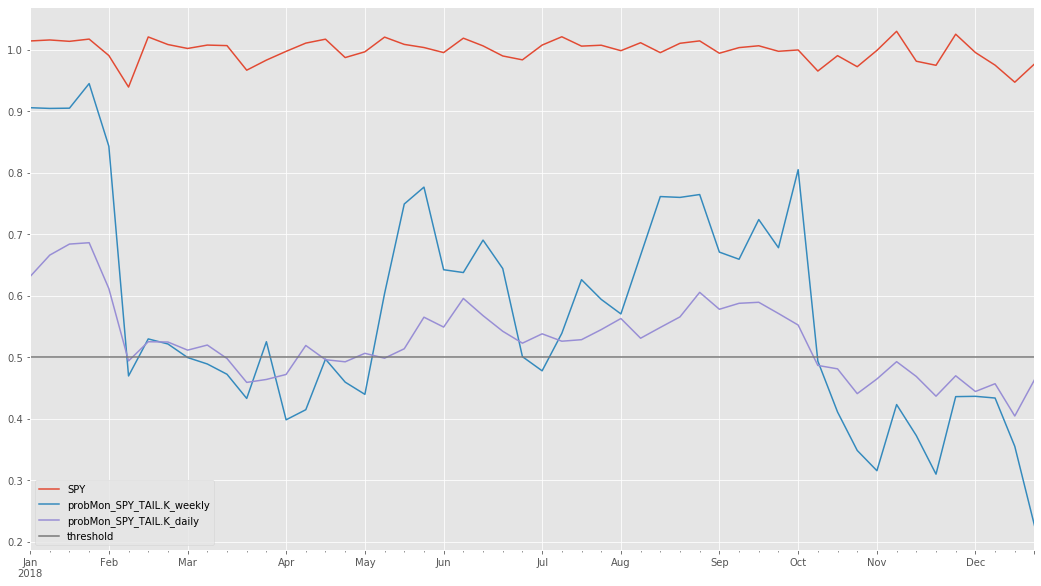

In [27]:
v_dateFromStr = '2018-01-01'
v_dateToStr = '2019-01-02'
graphTitle = f'Comparison of Momentum Curves from {v_dateFromStr} to {v_dateToStr}'
m = df_results.loc[v_dateFromStr:v_dateToStr,['SPY','probMon_SPY_TAIL.K_weekly','probMon_SPY_TAIL.K_daily','threshold']]
m.plot(figsize=(18,10))

df_results.loc[v_dateFromStr:v_dateToStr,['probMon_SPY_TAIL.K_weekly','probMon_SPY_TAIL.K_daily','threshold']]

---
## YEAR: 2019

probMon_SPY_TAIL.K_weekly probMon_SPY_TAIL.K_daily  threshold
2019-01-04                  0.324773                 0.459173        0.5
2019-01-11                  0.455942                 0.461841        0.5
2019-01-18                  0.449135                 0.486982        0.5
2019-01-25                  0.474908                 0.508117        0.5
2019-02-01                  0.537918                 0.492302        0.5
2019-02-08                  0.754672                  0.51945        0.5
2019-02-15                  0.906983                 0.540015        0.5
2019-02-22                  0.888614                 0.605826        0.5
2019-03-01                  0.969058                    0.618        0.5
2019-03-08                  0.815311                 0.624322        0.5
2019-03-15                  0.817237                  0.61324        0.5
2019-03-22                  0.784693                 0.551566        0.5
2019-03-29                  0.623743                 0.564428        0.5
2019-04-05                  0.658385                 0.577269        0.5
2019-04-12                  0.631126                 0.587905        0.5
2019-04-19                  0.631279                 0.560676        0.5
2019-04-26                  0.709769                 0.552641        0.5
2019-05-03                  0.673742                 0.547408        0.5
2019-05-10                  0.562352                 0.553123        0.5
2019-05-17                  0.555321                 0.509352        0.5
2019-05-24                  0.418393                 0.508925        0.5
2019-05-31                  0.310115                 0.459449        0.5
2019-06-07                  0.324373                 0.482089        0.5
2019-06-14                  0.422897                 0.479612        0.5
2019-06-21                  0.451965                 0.495045        0.5
2019-06-28                  0.490339                 0.485091        0.5
2019-07-05                  0.593172                  0.49996        0.5
2019-07-12                  0.616422                  0.53164        0.5
2019-07-19                   0.80281                 0.533074        0.5
2019-07-26                  0.778136                  0.56999        0.5
2019-08-02                  0.623309                  0.56247        0.5
2019-08-09                  0.423171                  0.50077        0.5
2019-08-16                  0.414047                 0.483519        0.5
2019-08-23                   0.37814                 0.462399        0.5
2019-08-30                  0.333563                 0.485887        0.5
2019-09-06                  0.407597                  0.48623        0.5
2019-09-13                  0.474872                 0.497493        0.5
2019-09-20                  0.514558                 0.496014        0.5
2019-09-27                  0.617655                 0.480273        0.5
2019-10-04                  0.580323                 0.501086        0.5
2019-10-11                   0.55141                 0.518066        0.5
2019-10-18                  0.645696                 0.541295        0.5
2019-10-25                  0.619354                 0.581769        0.5
2019-11-01                  0.578414                 0.566492        0.5
2019-11-08                   0.60896                 0.563803        0.5
2019-11-15                  0.698174                 0.540181        0.5
2019-11-22                  0.845567                 0.550966        0.5
2019-11-29                  0.885888                  0.57968        0.5
2019-12-06                  0.794261                 0.609346        0.5
2019-12-13                   0.79964                  0.61737        0.5
2019-12-20                  0.803135                 0.630459        0.5
2019-12-27                  0.787035                 0.617325        0.5

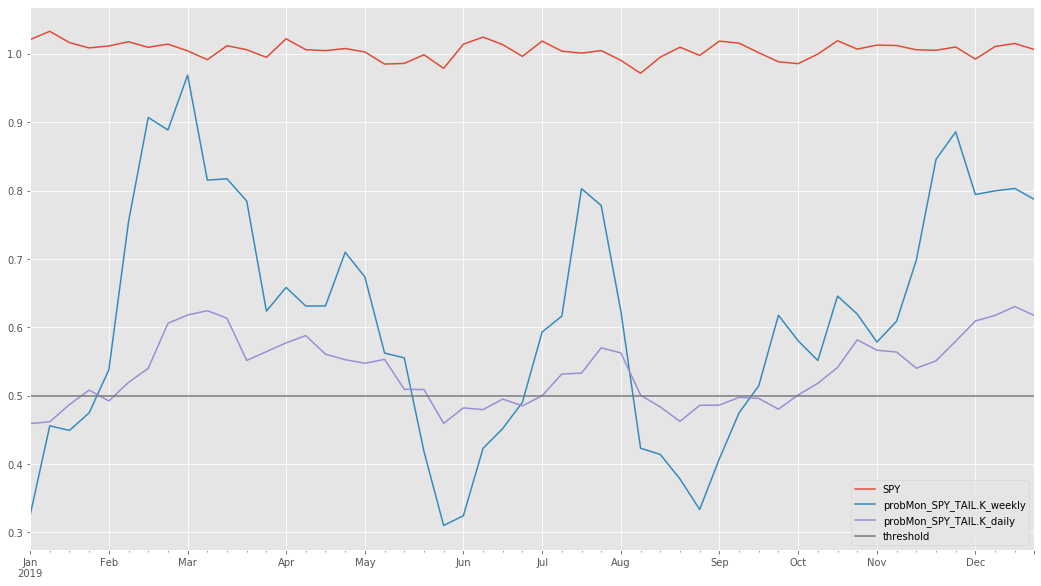

In [28]:
v_dateFromStr = '2019-01-01'
v_dateToStr = '2020-01-02'
graphTitle = f'Comparison of Momentum Curves from {v_dateFromStr} to {v_dateToStr}'
m = df_results.loc[v_dateFromStr:v_dateToStr,['SPY','probMon_SPY_TAIL.K_weekly','probMon_SPY_TAIL.K_daily','threshold']]
m.plot(figsize=(18,10))

df_results.loc[v_dateFromStr:v_dateToStr,['probMon_SPY_TAIL.K_weekly','probMon_SPY_TAIL.K_daily','threshold']]

---
## YEAR: 2020

probMon_SPY_TAIL.K_weekly probMon_SPY_TAIL.K_daily  threshold
2020-01-03                  0.745559                 0.593733        0.5
2020-01-10                  0.771587                 0.582585        0.5
2020-01-17                  0.774927                 0.601822        0.5
2020-01-24                  0.861595                 0.583544        0.5
2020-01-31                  0.582334                 0.514009        0.5
2020-02-07                  0.574498                  0.55114        0.5
2020-02-14                  0.600461                 0.560286        0.5
2020-02-21                  0.586351                 0.520932        0.5
2020-02-28                  0.393035                 0.406987        0.5
2020-03-06                  0.333299                 0.432271        0.5
2020-03-13                   0.27413                 0.428303        0.5
2020-03-20                  0.233661                 0.400953        0.5
2020-03-27                  0.245203                   0.4353        0.5
2020-04-03                  0.248725                 0.438882        0.5
2020-04-10                  0.337243                 0.457475        0.5
2020-04-17                  0.411756                 0.458877        0.5
2020-04-24                  0.426694                 0.460302        0.5
2020-05-01                  0.566045                 0.488787        0.5
2020-05-08                  0.786168                 0.498122        0.5
2020-05-15                  0.742156                 0.519155        0.5
2020-05-22                   0.75598                 0.580707        0.5
2020-05-29                  0.778632                 0.573921        0.5
2020-06-05                  0.778367                 0.613836        0.5
2020-06-12                  0.840585                 0.537341        0.5
2020-06-19                  0.728089                 0.539478        0.5
2020-06-26                  0.682816                 0.534797        0.5
2020-07-03                  0.706261                 0.554772        0.5
2020-07-10                  0.695363                 0.543726        0.5
2020-07-17                  0.665143                 0.564306        0.5
2020-07-24                  0.635607                 0.547264        0.5
2020-07-31                  0.617504                 0.538704        0.5
2020-08-07                  0.749021                 0.520039        0.5
2020-08-14                  0.919841                 0.592115        0.5
2020-08-21                  0.912222                 0.585038        0.5
2020-08-28                  0.905376                  0.68307        0.5
2020-09-04                  0.858795                 0.573308        0.5
2020-09-11                  0.610176                 0.544699        0.5
2020-09-18                  0.625525                 0.529501        0.5
2020-09-25                  0.485916                 0.524091        0.5
2020-10-02                  0.498792                 0.527622        0.5
2020-10-09                  0.544016                 0.539248        0.5
2020-10-16                  0.536557                 0.527797        0.5
2020-10-23                  0.511882                 0.527056        0.5
2020-10-30                  0.505301                 0.467877        0.5
2020-11-06                  0.560103                 0.533354        0.5
2020-11-13                  0.697846                 0.558863        0.5
2020-11-20                  0.665017                 0.554641        0.5
2020-11-27                  0.634984                 0.579215        0.5
2020-12-04                  0.627896                 0.581932        0.5
2020-12-11                  0.659842                 0.545646        0.5
2020-12-18                  0.818727                 0.557172        0.5
2020-12-25                   0.74964                 0.555124        0.5
2021-01-01                  0.839331                 0.641166        0.5

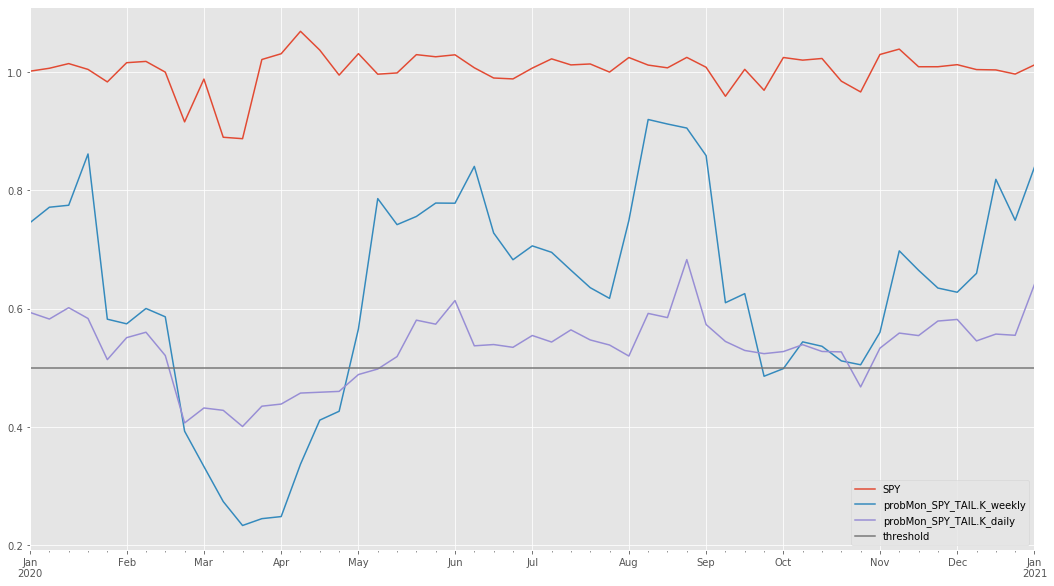

In [29]:
v_dateFromStr = '2020-01-01'
v_dateToStr = '2021-01-02'
graphTitle = f'Comparison of Momentum Curves from {v_dateFromStr} to {v_dateToStr}'
m = df_results.loc[v_dateFromStr:v_dateToStr,['SPY','probMon_SPY_TAIL.K_weekly','probMon_SPY_TAIL.K_daily','threshold']]
m.plot(figsize=(18,10))

df_results.loc[v_dateFromStr:v_dateToStr,['probMon_SPY_TAIL.K_weekly','probMon_SPY_TAIL.K_daily','threshold']]

---
## YEAR: 2021

probMon_SPY_TAIL.K_weekly probMon_SPY_TAIL.K_daily  threshold
2021-01-01                  0.839331                 0.641166        0.5
2021-01-08                  0.862899                 0.602306        0.5
2021-01-15                   0.86564                 0.562615        0.5
2021-01-22                   0.86758                 0.600589        0.5
2021-01-29                  0.636225                 0.523364        0.5
2021-02-05                  0.682483                  0.55393        0.5
2021-02-12                  0.753148                 0.579868        0.5
2021-02-19                  0.749435                 0.571985        0.5
2021-02-26                  0.682223                 0.554426        0.5
2021-03-05                  0.636125                 0.554614        0.5
2021-03-12                  0.669868                  0.55737        0.5
2021-03-19                  0.847768                 0.569712        0.5
2021-03-26                  0.746033                 0.564834        0.5
2021-04-02                  0.745933                 0.626774        0.5
2021-04-09                  0.770659                 0.601359        0.5
2021-04-16                  0.845283                 0.596037        0.5
2021-04-23                  0.822266                 0.584914        0.5
2021-04-30                  0.807361                 0.609479        0.5
2021-05-07                  0.733065                 0.619167        0.5
2021-05-14                  0.709132                   0.5623        0.5
2021-05-21                  0.652752                 0.560118        0.5
2021-05-28                  0.635083                 0.564777        0.5
2021-06-04                  0.604565                 0.552164        0.5
2021-06-11                  0.628503                 0.523109        0.5
2021-06-18                   0.55028                 0.487662        0.5
2021-06-25                  0.614104                 0.532017        0.5
2021-07-02                  0.809476                 0.538021        0.5
2021-07-09                  0.789199                 0.528781        0.5
2021-07-16                  0.760482                 0.522054        0.5
2021-07-23                  0.575114                 0.544142        0.5
2021-07-30                   0.64568                 0.521052        0.5
2021-08-06                    0.6582                 0.534031        0.5
2021-08-13                  0.688062                 0.539589        0.5
2021-08-20                  0.569508                 0.557938        0.5
2021-08-27                  0.635155                 0.540467        0.5
2021-09-03                  0.664162                  0.53864        0.5
2021-09-10                  0.697467                 0.518262        0.5
2021-09-17                  0.584454                 0.530089        0.5
2021-09-24                  0.520733                 0.528102        0.5
2021-10-01                  0.445725                 0.493607        0.5

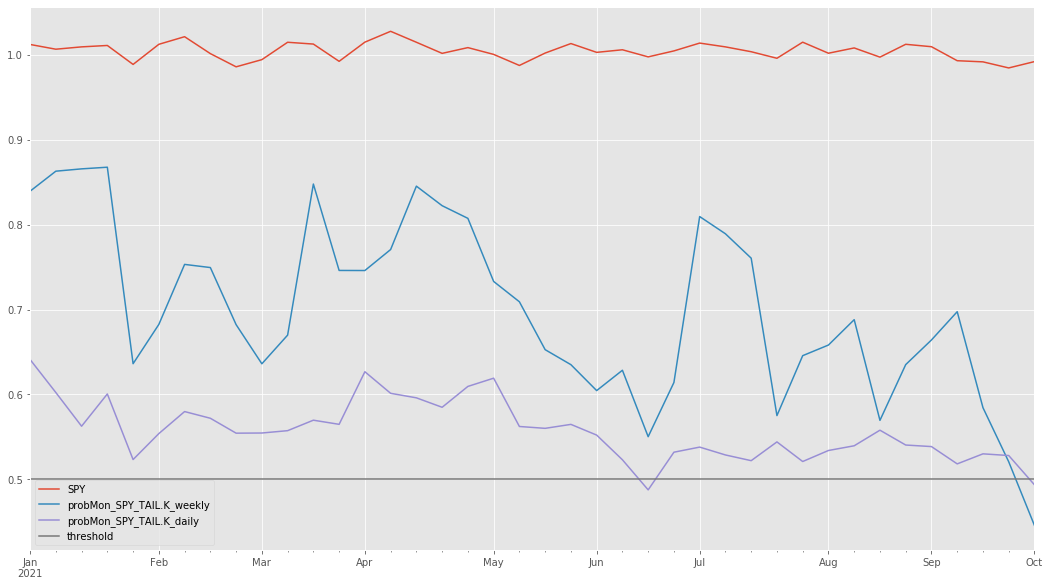

In [30]:
v_dateFromStr = '2021-01-01'
v_dateToStr = '2021-10-01'
graphTitle = f'Comparison of Momentum Curves from {v_dateFromStr} to {v_dateToStr}'
m = df_results.loc[v_dateFromStr:v_dateToStr,['SPY','probMon_SPY_TAIL.K_weekly','probMon_SPY_TAIL.K_daily','threshold']]
m.plot(figsize=(18,10))

df_results.loc[v_dateFromStr:v_dateToStr,['probMon_SPY_TAIL.K_weekly','probMon_SPY_TAIL.K_daily','threshold']]